In [1]:
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
import wradlib as wrl

In [2]:
# read data
f = '2019-11-09_0000.mvol'
vol = wrl.io.open_gamic_dataset(f)
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 17)
Elevation(s): (0.9, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.5, 12.0, 13.5, 15.0, 16.5, 18.0, 19.0)

In [3]:
# Iterate over sweeps and process
swp_list = []
for v in vol:
# georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)

In [4]:
# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")
display(vol0)

<xarray.Dataset>
Dimensions:     (points: 1897200)
Coordinates: (12/14)
    z           (points) float64 106.4 114.8 123.2 ... 2.295e+04 2.312e+04
    elevation   (points) float64 0.9613 0.9613 0.9613 ... 19.04 19.04 19.04
    rtime       (points) datetime64[ns] 2019-11-09T00:00:37.609999872 ... 201...
    time        (points) datetime64[ns] 2019-11-09T00:00:14.059000064 ... 201...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 -59.99
    ...          ...
    x           (points) float64 2.181 6.544 10.91 ... -565.6 -569.7 -573.8
    y           (points) float64 250.0 749.9 1.25e+03 ... 6.528e+04 6.575e+04
    gr          (points) float64 250.0 749.9 1.25e+03 ... 6.528e+04 6.575e+04
    rays        (points) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    bins        (points) float32 250.0 750.0 1.25e+03 ... 6.925e+04 6.975e+04
  * points      (points) MultiIndex
  - azimuth     (points) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
  - range       (points) float64 250.0 750.0 1.25e+03 ... 6.925e+04 6.975e+04
Data variables:
    uz          (points) float32 -32.0 nan nan nan 6.652 ... nan nan nan nan nan
    v           (points) float32 nan -8.313 nan nan -16.38 ... nan nan nan nan
    w           (points) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    fixed_angle:  0.9

In [5]:
# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()

In [6]:
# Create Target 3D Grid
maxrange = 240000
minelev  = 0.0
maxelev  = 19.
maxalt   = 18000. # 18000 # 18 km
horiz_res = 1000 # 1 km
vert_res  = 1000  #1000. # 1 km
trgx = np.arange(xyz[:, 0].min(),xyz[:, 0].max(), horiz_res)
trgy = np.arange(xyz[:, 1].min(),xyz[:, 1].max(), horiz_res)
trgz = np.arange(0, maxalt, vert_res)

In [7]:
trgx.shape, trgy.shape, trgz.shape

((480,), (480,), (18,))

In [8]:
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T

In [9]:
# Create Gridder/Interpolator
trgshape = xx.shape
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                        gridcoords=trgxyz,
                        maxrange=maxrange,
                        minelev=minelev,
                        maxelev=maxelev,
                        ipclass=wrl.ipol.Nearest)

In [10]:
# Interpolate Data into 3D Grid
crtd_ref = vol0.uz
vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))

In [11]:
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)

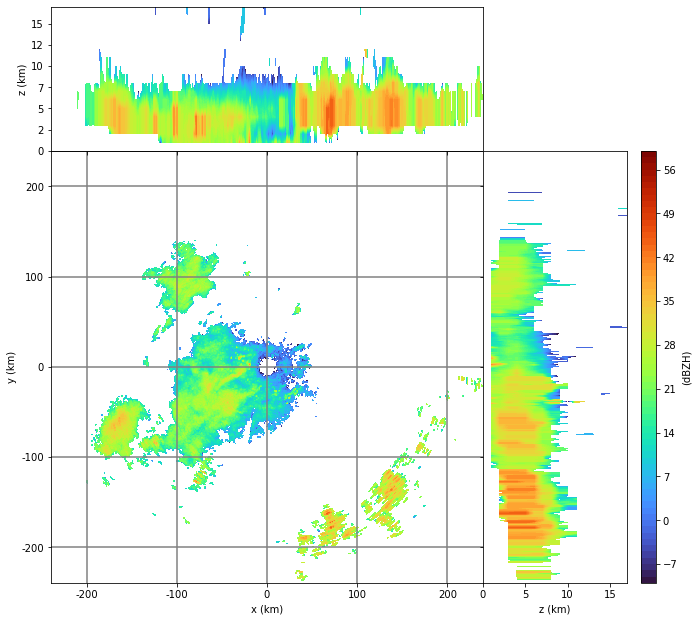

In [12]:
# Plot MAXCAPPI
wrl.vis.plot_max_plan_and_vert(trgx, trgy, trgz, vol_zh, unit="dBZH", cmap="turbo", levels=range(-10, 60))

#For real CAPPI you would just need to plot the single wanted height layer.